- **E** = extended strand, participates in β ladder
- **B** = residue in isolated β-bridge
- **H** = α-helix
- **G** = 3-helix (3-10 helix)
- **I** = 5-helix (π-helix)
- **T** = hydrogen bonded turn
- **S** = bend
- **_** = loop (any other type)


In [77]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Conv1D, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.utils import to_categorical
import os

In [78]:
# Rutas de los conjuntos de datos
# Obtener el directorio actual del notebook
current_dir = os.getcwd()

# Dataset reducido, contiene las primeras 800 proteinas del dataset cullpdb+profile_6133.npy
#dataset_path = os.path.join(current_dir, 'data', 'cullpdb+profile_6133_reduced_800.npy')

# Construye la ruta relativa al archivo
dataset_path = os.path.join(current_dir, 'data', 'cullpdb+profile_6133.npy')

cb513_path = os.path.join(current_dir, 'data', 'cb513+profile_split1.npy')

# Parámetros del modelo
sequence_len = 700
amino_acid_residues = 21
num_classes = 8
class_labels = ['L', 'B', 'E', 'G', 'I', 'H', 'S', 'T']
total_features = 57

In [79]:
"""
Los datasets en su forma original (N proteínas x k características), y se les da la forma (N proteínas x 700 aminoácidos x 57 características).
Las 57 características son:
[0,22): resíduos de aminoácidos, en el orden 'A', 'C', 'E', 'D', 'G', 'F', 'I', 'H', 'K', 'M', 'L', 'N', 'Q', 'P', 'S', 'R', 'T', 'W', 'V', 'Y', 'X','NoSeq'
[22,31): etiquetas de la estructura secundaria: 'L', 'B', 'E', 'G', 'I', 'H', 'S', 'T','NoSeq'
[31,33): N- y C- terminales
[33,35): accesibilidad al solvente relativa y absoluta
[35,57): perfiles de las sequencias. el orden de los aminoacídos aquí es ACDEFGHIKLMNPQRSTVWXY
la última característica de los aminoacídos y de las etiquetas de la estructura secundaria marcan el fin de la secuencia de proteinas. 
"""


"\nLos datasets en su forma original (N proteínas x k características), y se les da la forma (N proteínas x 700 aminoácidos x 57 características).\nLas 57 características son:\n[0,22): resíduos de aminoácidos, en el orden 'A', 'C', 'E', 'D', 'G', 'F', 'I', 'H', 'K', 'M', 'L', 'N', 'Q', 'P', 'S', 'R', 'T', 'W', 'V', 'Y', 'X','NoSeq'\n[22,31): etiquetas de la estructura secundaria: 'L', 'B', 'E', 'G', 'I', 'H', 'S', 'T','NoSeq'\n[31,33): N- y C- terminales\n[33,35): accesibilidad al solvente relativa y absoluta\n[35,57): perfiles de las sequencias. el orden de los aminoacídos aquí es ACDEFGHIKLMNPQRSTVWXY\nla última característica de los aminoacídos y de las etiquetas de la estructura secundaria marcan el fin de la secuencia de proteinas. \n"

In [80]:
# Función para cargar el conjunto de datos
def get_dataset(path):
    ds = np.load(path)
    ds = np.reshape(ds, (ds.shape[0], sequence_len, total_features))
    ret = np.zeros((ds.shape[0], ds.shape[1], amino_acid_residues + num_classes))
    ret[:, :, 0:amino_acid_residues] = ds[:, :, 35:56]
    ret[:, :, amino_acid_residues:] = ds[:, :, amino_acid_residues + 1:amino_acid_residues+ 1 + num_classes]
    return ret

def split_with_shuffle(Dataset, seed=None):
    np.random.seed(seed)
    np.random.shuffle(Dataset)
    train_split = int(Dataset.shape[0]*0.8)
    test_val_split = int(Dataset.shape[0]*0.1)
    Train = Dataset[0:train_split, :, :]
    Test = Dataset[train_split:train_split+test_val_split, :, :]
    Validation = Dataset[train_split+test_val_split:, :, :]
    return Train, Test, Validation

# Función para dividir el conjunto de datos como en el paper
def split_like_paper(dataset):
    Train = dataset[:5600]
    Test = dataset[5600:5877]
    Validation = dataset[5877:]
    return Train, Test, Validation

# Función para obtener los datos y las etiquetas
def get_data_labels(dataset):
    X = dataset[:, :, :amino_acid_residues]
    Y = dataset[:, :, amino_acid_residues:amino_acid_residues + num_classes]
    return X, Y


In [81]:
"""
Esta parte la incluí después de la exposición del proyecto.

Aquí se crea una función de loss para que tenga en cuenta las diferencias en la 
representitividad de las categorias a predecir en el dataset.

Esto mejora el desempeño del modelo en el validation set, pero al entrenarlo de 
esta manera el modelo pierde capacidad de generalizacion, ya que su capacidad de 
predicción en el dataset CB513 disminuye, ya que en ese conjunto las estructuras secundarias
no tienen la misma representatividad.
"""
# y_integers = np.argmax(Y_train, axis=-1).flatten()
# class_weights = compute_class_weight('balanced', classes=np.arange(num_classes), y=y_integers)
# class_weights_dict = dict(enumerate(class_weights))

# def weighted_categorical_crossentropy(weights):
#     weights = tf.constant(weights, dtype=tf.float32)
    
#     def loss(y_true, y_pred):
#         y_true = tf.cast(y_true, tf.float32)
#         y_pred = tf.cast(y_pred, tf.float32)
        
#         # Calcula la entropía cruzada sin ponderar
#         cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        
#         # Aplicar los pesos
#         weights_v = tf.reduce_sum(weights * y_true, axis=-1)
#         weighted_loss = cross_entropy * weights_v
        
#         return tf.reduce_mean(weighted_loss)
    
#     return loss

# # Crear la función de pérdida con los pesos calculados
# class_weights_array = np.array([class_weights_dict[i] for i in range(num_classes)])
# weighted_loss = weighted_categorical_crossentropy(class_weights_array)


'\nEsta parte la incluí después de la exposición del proyecto.\n\nAquí se crea una función de loss para que tenga en cuenta las diferencias en la \nrepresentitividad de las categorias a predecir en el dataset.\n\nEsto mejora el desempeño del modelo en el validation set, pero al entrenarlo de \nesta manera el modelo pierde capacidad de generalizacion, ya que su capacidad de \npredicción en el dataset CB513 disminuye, ya que en ese conjunto las estructuras secundarias\nno tienen la misma representatividad.\n'

In [82]:
# Función para crear el modelo CNN
def CNN_model(): # Si se quiere utilizar la funcion de loss weighted_categorical_crossentropy se debe incluir weighted_loss como argumento de CNN_model
    model = Sequential([
        Conv1D(96, 7, padding='same', activation='relu', input_shape=(sequence_len, amino_acid_residues), kernel_regularizer=l2(0.00005)),
        BatchNormalization(),
        Dropout(0.3),
        Conv1D(64, 7, padding='same', activation='relu', kernel_regularizer=l2(0.0002)),
        BatchNormalization(),
        Dropout(0.4),
        Conv1D(num_classes, 11, padding='same', activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0003),
                  loss='categorical_crossentropy', #Cambiar 'categorical_crossentropy' por weighted_loss
                  metrics=['accuracy', 'mae'])
    model.summary()

    return model


In [83]:
# Cargar los datos
dataset = get_dataset(dataset_path)
CB513_X, CB513_Y = get_data_labels(get_dataset(cb513_path))

# Dividir los datos
#D_train, D_test, D_val = split_like_paper(dataset)
D_train, D_test, D_val = split_with_shuffle(dataset, 100)
X_train, Y_train = get_data_labels(D_train)
X_test, Y_test = get_data_labels(D_test)
X_val, Y_val = get_data_labels(D_val)

C:\Users\DAVID\AppData\Local\Temp\ipykernel_1316\750174458.py:3: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  ds = np.load(path)


In [84]:
# Función para calcular la precisión Q8
def Q8_accuracy(real, pred):
    mask = np.sum(real, axis=-1) > 0
    correct = np.sum((np.argmax(real, axis=-1) == np.argmax(pred, axis=-1)) & mask)
    total = np.sum(mask)
    return correct / total

In [85]:
# Crear el modelo CNN
net = CNN_model() # Para crear el modelo con la función de pérdida ponderada incluir weighted_loss como argumento

# Callbacks
lr_scheduler = LearningRateScheduler(lambda epoch: 0.00002 * (0.1 ** (epoch//10)))
filepath = os.path.join(current_dir, 'results', 'Whole_CullPDB-best.keras')
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [lr_scheduler, checkpoint]

# Entrenar el modelo
history = net.fit(X_train, Y_train, epochs=20, batch_size=64, shuffle=True,
                  validation_data=(X_val, Y_val), callbacks=callbacks_list)

c:\Users\DAVID\anaconda3\envs\ML_tensorflow\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 700, 96)        │        14,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 700, 96)        │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 700, 96)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 700, 64)        │        43,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 700, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 700, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 700, 8)         │         5,640 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,560 (248.28 KB)

 Trainable params: 63,240 (247.03 KB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.1135 - loss: 1.1854 - mae: 0.1502
Epoch 1: val_accuracy improved from -inf to 0.08177, saving model to c:\Users\DAVID\ML_pssp\results\Whole_CullPDB-best.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 30s 344ms/step - accuracy: 0.1134 - loss: 1.1850 - mae: 0.1502 - val_accuracy: 0.0818 - val_loss: 0.5766 - val_mae: 0.1503 - learning_rate: 2.0000e-05
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.1006 - loss: 1.0338 - mae: 0.1482
Epoch 2: val_accuracy improved from 0.08177 to 0.09655, saving model to c:\Users\DAVID\ML_pssp\results\Whole_CullPDB-best.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - accuracy: 0.1006 - loss: 1.0333 - mae: 0.1482 - val_accuracy: 0.0965 - val_loss: 0.5491 - val_mae: 0.1483 - learning_rate: 2.0000e-05
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.1010 - loss: 0.9146 - mae: 0.1467
Epoch 3: val_accuracy improved from 0.09655 to 0.10762, saving model to c:\Users\DAVID\ML_p

In [86]:
# Evaluar el modelo en los datos de prueba y CB513
test_accuracy = Q8_accuracy(Y_test, net.predict(X_test))
cb513_accuracy = Q8_accuracy(CB513_Y, net.predict(CB513_X))
print("\n\nQ8 accuracy on Test Dataset: {:.4f}".format(test_accuracy))
print("Q8 accuracy on CB513 Dataset: {:.4f}\n\n".format(cb513_accuracy))

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Q8 accuracy on Test Dataset: 0.5140
Q8 accuracy on CB513 Dataset: 0.4738




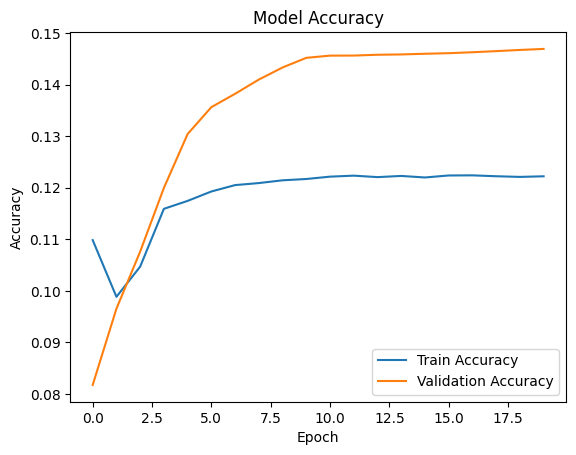

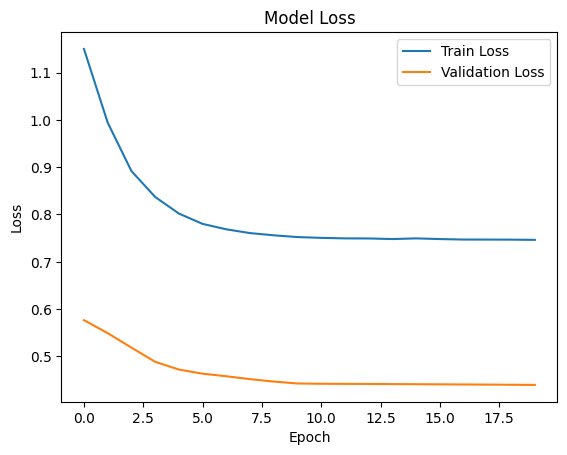

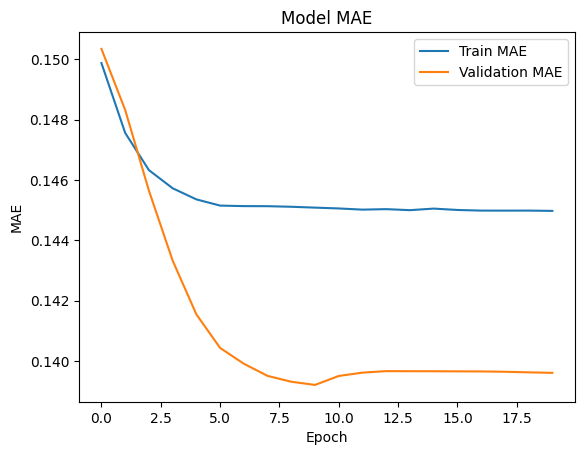

In [87]:
# Graficar historias de entrenamiento
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [88]:
def plot_confusion_matrix(y_true, y_pred, classes):
    y_true_labels = np.argmax(y_true, axis=-1).flatten()
    y_pred_labels = np.argmax(y_pred, axis=-1).flatten()
    
    # Filtrar etiquetas válidas
    valid_idx = y_true_labels != 8  # Aquí 8 es la etiqueta de padding, ajustar según el caso
    y_true_labels = y_true_labels[valid_idx]
    y_pred_labels = y_pred_labels[valid_idx]

    cm = confusion_matrix(y_true_labels, y_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


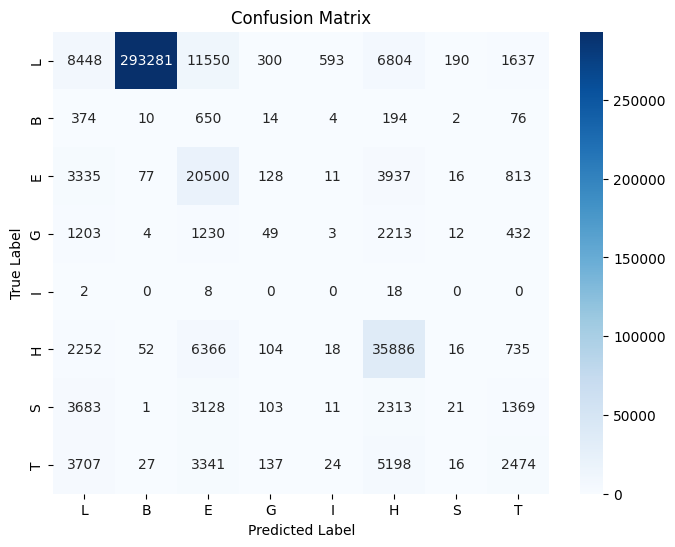

In [89]:
plot_confusion_matrix(Y_test, net.predict(X_test), classes=class_labels)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


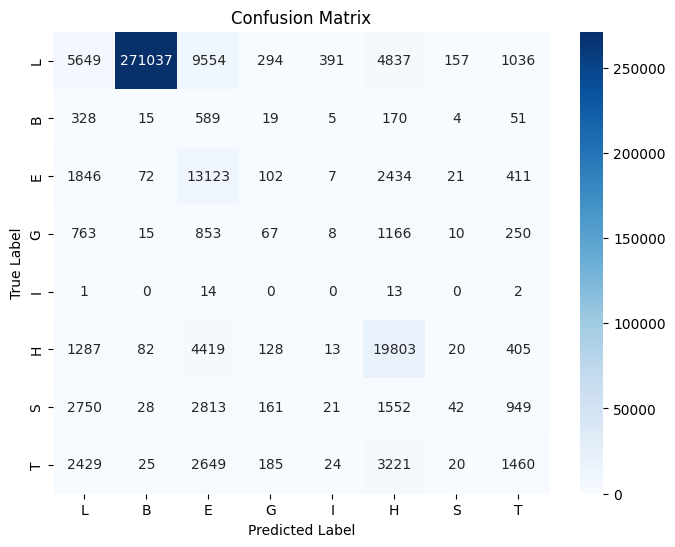

In [90]:
plot_confusion_matrix(CB513_Y, net.predict(CB513_X), classes=class_labels)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


Q8 accuracy on Test Dataset: 0.6269
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Q8 accuracy on CB513 Dataset: 0.5915




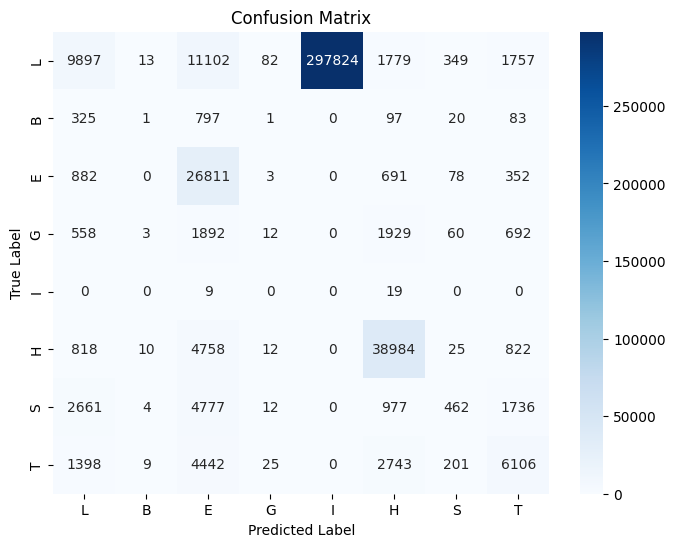

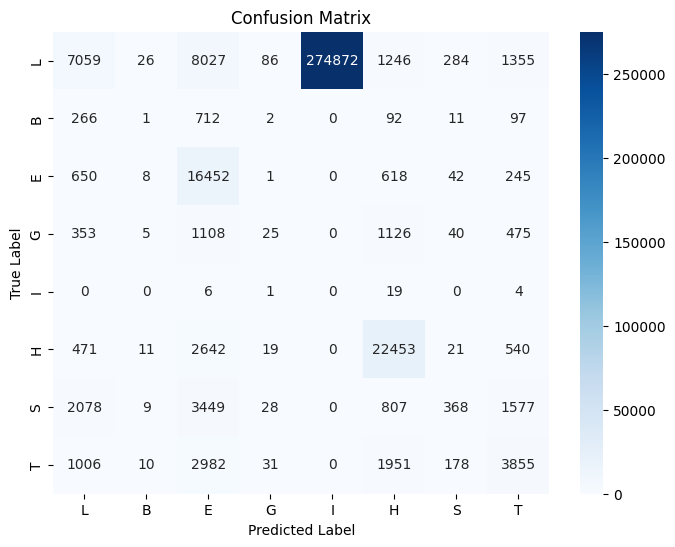

In [91]:
from keras.models import load_model

# Cargar el modelo guardado
net_val = load_model(os.path.join(current_dir, 'model', 'Whole_CullPDB_Q8_CB513_0.59.keras'))

# Realizar predicciones en el conjunto de prueba
predictions_test = net_val.predict(X_test)
test_accuracy = Q8_accuracy(Y_test, predictions_test)
print("\n\nQ8 accuracy on Test Dataset: {:.4f}".format(test_accuracy))

# Realizar predicciones en CB513
predictions_cb513 = net_val.predict(CB513_X)
cb513_accuracy = Q8_accuracy(CB513_Y, predictions_cb513)
print("Q8 accuracy on CB513 Dataset: {:.4f}\n\n".format(cb513_accuracy))

# Matriz de confusión para el conjunto de prueba
plot_confusion_matrix(Y_test, predictions_test, class_labels)

# Matriz de confusión para CB513
plot_confusion_matrix(CB513_Y, predictions_cb513, class_labels)
